# Agent-Based Kinetics via Topology (ABa-KiTo)
Date: 25.10.2025

In this notebook I realiye the graph analyisis when the data was initialized with N=5 intervals

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist
import pickle


import sys
import os
import torch as pt
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("NumPy version:", np.__version__)
print("Torch version:", pt.__version__)


NumPy version: 1.26.4
Torch version: 2.3.0+cpu


In [2]:
# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..",'..'))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.modules_mokito import *
from src.diagnose_clustering_results import *

In [3]:
#Load data formatted from ABM simulations and ISOKANN.jl 

# Create the path and ensure the directory exists for saving the data
data_path = os.path.join('data', 'processed', 'isokann', '001_results')
data_dir =  os.path.join(project_root, data_path,'')
# Read data
states_data = np.load(data_dir + '2025-10-20-data_VD_FC_3InteractingAgents_rand_init_capital.npz')
xs = states_data['xs'] #xs.shape (n_dim, n_samples)
ys = states_data['ys'] #ys-shape (n_dim, n_koop = 1, n_samples)

#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)
Xt = np.transpose(ys, (2, 1, 0))   # (n_samples, 1, n_dim)

# --- Log + Scale both X0 and Xt consistently ---
scaler = StandardScaler()

# X0
X0_log = np.log1p(X0)
X0_scaled = scaler.fit_transform(X0_log)   # (n_samples, n_dim)

# Xt: flatten for scaling
Xt_flat = Xt.reshape(-1, Xt.shape[2])      # (n_samples * n_koop, n_dim)
Xt_log = np.log1p(Xt_flat)
Xt_scaled = scaler.transform(Xt_log)
Xt_scaled = Xt_scaled.reshape(Xt.shape)    # (n_samples, 1, n_dim)


# # # --- Load chi function ---
chivals_path = os.path.join('data', 'processed', 'isokann', '001_results', 'chi_vals', '')
chivals_dir = os.path.join(project_root, chivals_path)
chi0 = np.load(data_dir + '/chi_vals/chi_values_rand_init_capitals.npz')

# --- Organize for MoKiTo ---
data = OrganizeData(X0_scaled, Xt_scaled, chi0)





Check shape of input data
X0.shape   =  (200000, 202)
Xt.shape   =  (200000, 1, 202)
chi0.shape =  (200000,)
  


In [4]:
#Reload clustering results:
n_intervals =3
seed = 42
# Load the specific run you want to use (Nintervals=5, seed=42 for example)
with open(f'stability_results/Nint{n_intervals}_seed{seed}_FNs.pkl', 'rb') as f:
    FNs = pickle.load(f)

with open(f'stability_results/Nint{n_intervals}_seed{seed}_FCs.pkl', 'rb') as f:
    FIs = pickle.load(f)


χ-function interval distribution:
chi0 range: [-0.012, 1.031]
chi0 mean: 0.237, std: 0.158
  Interval 0: 131299 points ( 65.6%), χ ∈ [-0.012, 0.244]
  Interval 1:  59102 points ( 29.6%), χ ∈ [0.244, 0.554]
  Interval 2:   9599 points (  4.8%), χ ∈ [0.554, 1.031]


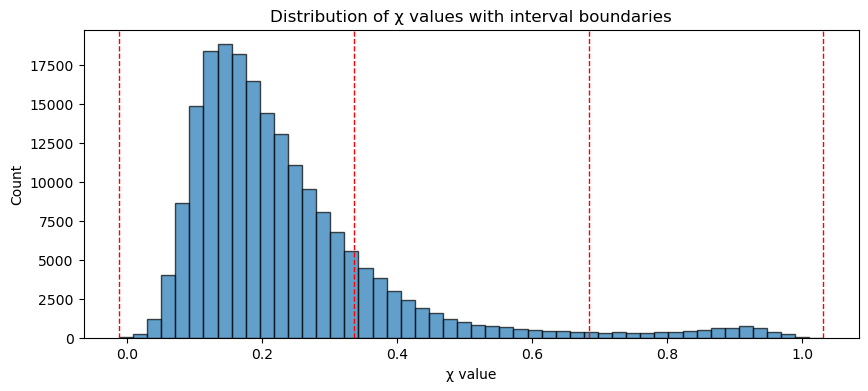

In [5]:
print("\nχ-function interval distribution:")
print(f"chi0 range: [{data.chi0.min():.3f}, {data.chi0.max():.3f}]")
print(f"chi0 mean: {data.chi0.mean():.3f}, std: {data.chi0.std():.3f}")

chi_bins = []  # list to store (min, max) tuples

for i in range(FIs.Nintervals):
    interval_points = FIs.size_intervals[i] if i < len(FIs.size_intervals) else 0
    chi_vals = data.chi0[FIs.chi_intervals == i]

    if len(chi_vals) > 0:
        chi_min, chi_max = chi_vals.min(), chi_vals.max()
        chi_bins.append((chi_min, chi_max))
        print(f"  Interval {i}: {interval_points:6d} points ({interval_points/len(data.chi0)*100:5.1f}%), "
              f"χ ∈ [{chi_min:.3f}, {chi_max:.3f}]")
    else:
        chi_bins.append((None, None))  # placeholder for empty interval
        print(f"  Interval {i}: {interval_points:6d} points (empty)")

# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(data.chi0, bins=50, edgecolor='black', alpha=0.7)
intervals = n_intervals
for edge in np.linspace(data.chi0.min(), data.chi0.max(), intervals + 1):
    plt.axvline(edge, color='red', linestyle='--', linewidth=1)
plt.xlabel('χ value')
plt.ylabel('Count')
plt.title('Distribution of χ values with interval boundaries')
plt.show()

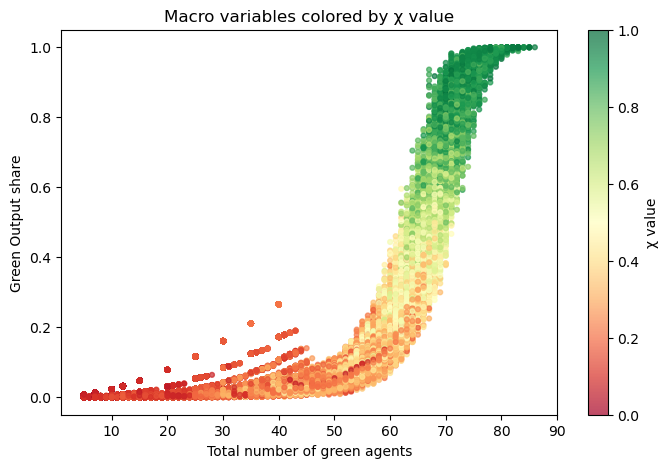

In [6]:
#Scatter plot of macro variables colored by chi interval for practical interpretation of ISOKANN output
# Example data
import matplotlib.colors as mcolors

macro = X0[:, -2:]
chi_intervals = FIs.chi_intervals  # values: 0, 1, 2

macro1 = "Total number of green agents"
macro2 = "Green Output share"

labels = [f"[{low:.1f}, {high:.1f}]" for low, high in chi_bins]

#color map
#cmap=plt.cm.viridis
cmap=plt.cm.RdYlGn


# Plot
plt.figure(figsize=(8,5))
sc = plt.scatter(macro[:,0], macro[:,1],
                 c=chi0, #chi_values, 
                 cmap=cmap,
                 s=12, alpha=0.7,
                 vmin=0, vmax=1       # ensure colors go from 0 to 1
                 )

# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("χ value")


plt.xlabel(macro1)
plt.ylabel(macro2)
plt.title("Macro variables colored by χ value")
#plt.show()

plt.savefig("N3intervals_results/macro_vars_colored_by_chi_vals.png")

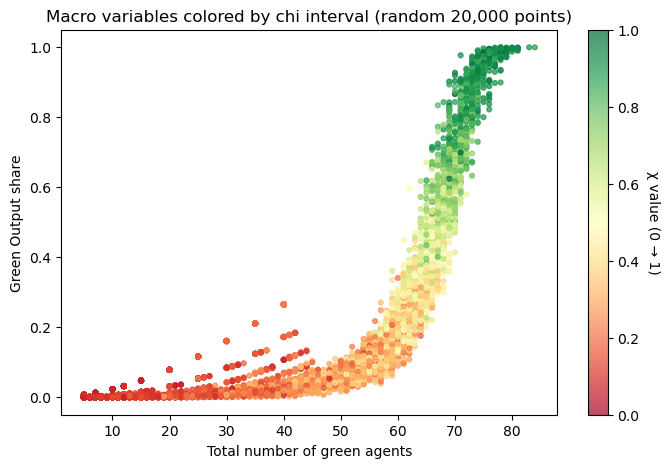

In [7]:
#Plot random points of the data set
#color map
#cmap=plt.cm.viridis
#cmap=plt.cm.PiYG
cmap=plt.cm.RdYlGn
# Randomly sample 20,000 points (without replacement)
sample_size = 20000
n = len(macro)

# Ensure we don't sample more than available
sample_size = min(sample_size, n)

idx = np.random.choice(n, sample_size, replace=False)

macro_sampled = macro[idx]
chi_sampled = chi0[idx]

# Plot
plt.figure(figsize=(8,5))
sc = plt.scatter(
    macro_sampled[:, 0],
    macro_sampled[:, 1],
    c=chi_sampled,
    cmap=cmap,
    s=12, alpha=0.7,
    vmin=0, vmax=1
)

plt.xlabel(macro1)
plt.ylabel(macro2)
plt.title(f"Macro variables colored by chi interval (random {sample_size:,} points)")

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label("χ value (0 → 1)", rotation=270, labelpad=15)

plt.show()


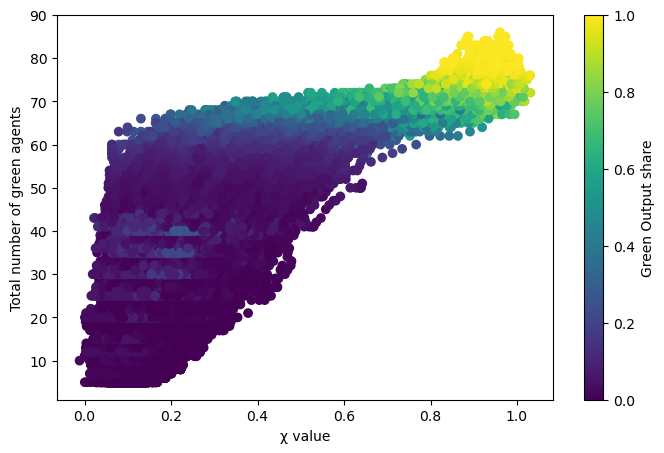

In [8]:
#Number of green farms vs chi values colored by green output share
# Randomly sample 20,000 points (without replacement)
sample_size = 20000
n = len(macro)

# Ensure we don't sample more than available
sample_size = min(sample_size, n)

idx = np.random.choice(n, sample_size, replace=False)

macro_sampled = macro[idx]
chi_sampled = chi0[idx]

#color map
#cmap=plt.cm.BrBG
#cmap=plt.cm.RdYlGn
cmap=plt.cm.viridis
plt.figure(figsize=(8,5))
sc = plt.scatter(chi0, macro[:,0],
                  c=macro[:,1] ,
                  cmap=cmap,
                  vmin=0, vmax=1 
                  )

# Plot random points
# sc = plt.scatter(chi_sampled, macro_sampled[:,0],
#                  c=  macro_sampled[:, 1],
#                  cmap=cmap,
#     s=12, alpha=0.7,
#     vmin=0, vmax=1
# )
# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("Green Output share")

plt.ylabel(macro1)
plt.xlabel("χ value")

plt.savefig("N3intervals_results/GFarms_vs_chi_vals.png")

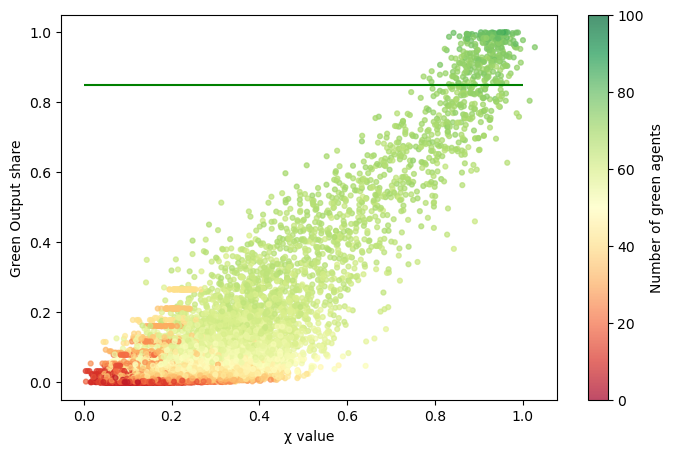

In [9]:
# chi-values against green Output share
cmap=plt.cm.RdYlGn

plt.figure(figsize=(8,5))
sc = plt.scatter(chi_sampled, macro_sampled[:,1],
                 c=  macro_sampled[:, 0],
                 cmap=cmap,
    s=12, alpha=0.7,
    vmin=0, vmax=100
)

plt.hlines(y=0.85, xmin=-0, xmax=1, colors='green')
plt.ylabel(macro2)
plt.xlabel("χ value")

# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("Number of green agents")

plt.savefig("N3intervals_results/GOS_vs_chi_vals.png")

In [5]:
#Clustering results
noise_pct = np.sum(FNs.nodes == -1) / len(FNs.nodes) * 100
print(f"Result: {FNs.Nnodes} clusters, {noise_pct:.1f}% noise\n\n")
print(f"Cluster sizes - min: {FNs.nodes_size.min()}, max: {FNs.nodes_size.max()}, median: {np.median(FNs.nodes_size):.0f}")
print(f"Clusters per interval: {[np.sum(FNs.index_chi_node == i) for i in range(FIs.Nintervals)]}\n")

for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

Result: 6 clusters, 6.6% noise


Cluster sizes - min: 73, max: 89339, median: 19001
Clusters per interval: [2, 2, 2]

Node, interval, size: 0 0 32283
Node, interval, size: 1 0 89339
Node, interval, size: 2 1 56234
Node, interval, size: 3 1 73
Node, interval, size: 4 2 5719
Node, interval, size: 5 2 3138


In [ ]:
# BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=100, threshold =0, algorithm='mlp')
#BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=100, threshold =8, algorithm='mlp')

In [6]:
import pickle

# Save the BAM object
# with open('BAM_object.pkl', 'wb') as f:
#     pickle.dump(BAM, f)

# Later, load it back
with open('BAM_object.pkl', 'rb') as f:
    BAM = pickle.load(f)

In [7]:
BAM.A

array([[1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 1, 1]])

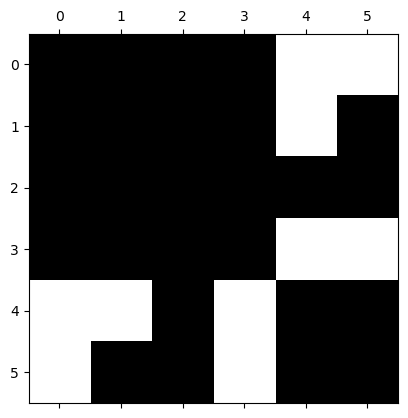

In [8]:
BG     =  BuildGraph(FNs, BAM)
G      =  BG.G

plt.spy(BAM.A) #show the sparsity pattern of a matrix.

In [9]:
chi_nodes          = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)
gradient_chi_nodes = np.zeros((FNs.Nnodes,FNs.Nnodes))

for i in range(FNs.Nnodes):
    for j in range(FNs.Nnodes):
         gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]

C:\Users\Flo\AppData\Local\Temp\ipykernel_13096\2595845277.py:6: RuntimeWarning: invalid value encountered in divide
  gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]
C:\Users\Flo\AppData\Local\Temp\ipykernel_13096\2595845277.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]


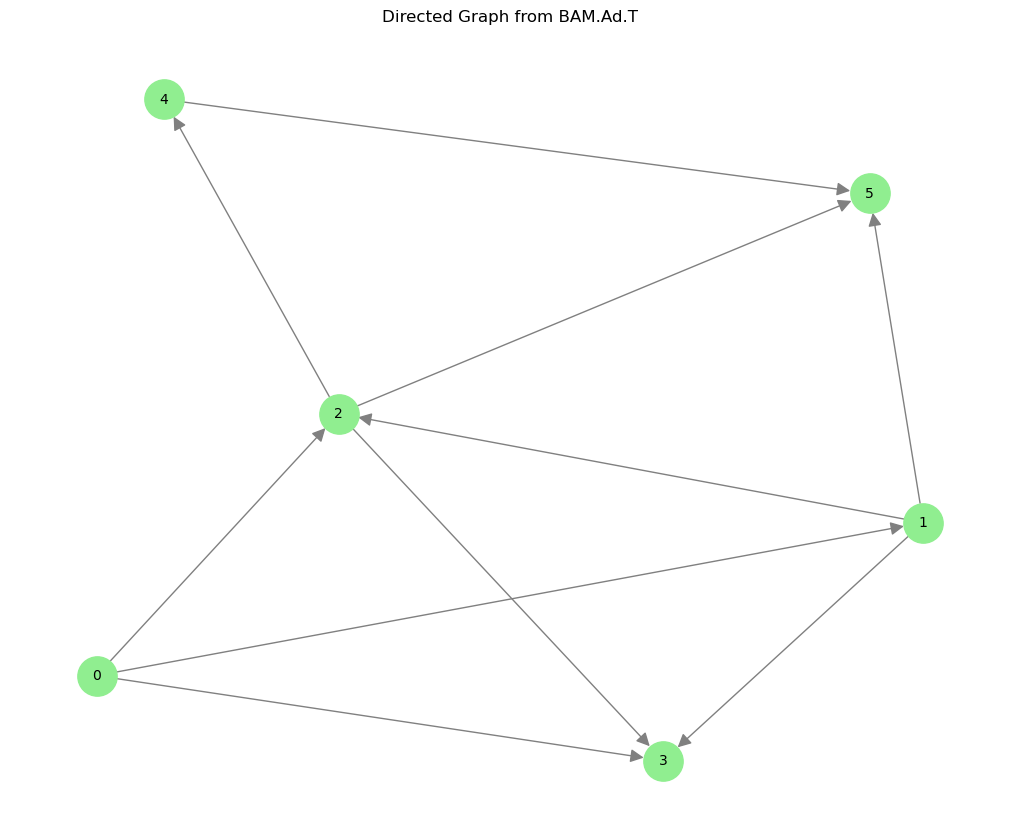

In [17]:
A = BAM.Ad.T
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

plt.figure(figsize=(10, 8))
# pos = nx.kamada_kawai_layout(G)  # or spring_layout, circular_layout, etc.
pos1 = nx.kamada_kawai_layout(BG.G)
# Rotate 180 degrees
pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightgreen',
    edge_color='gray',
    node_size=800,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>',
    font_size=10
)

plt.title("Directed Graph from BAM.Ad.T")
plt.show()


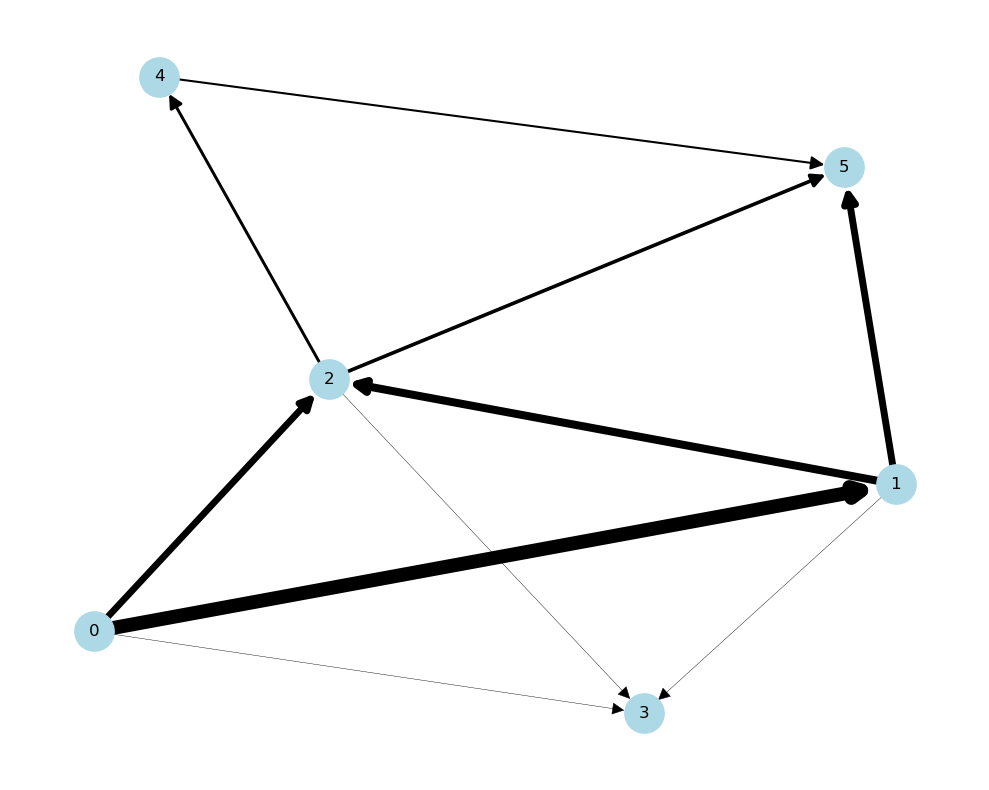

In [18]:
# Create directed graph with weights from C but directionality from Ad.T
Gd = nx.DiGraph()

for i in range(BAM.Ad.T.shape[0]):
    for j in range(BAM.Ad.T.shape[1]):
        if BAM.Ad.T[i, j] > 0:  # Only add edge if it exists in Ad (unidirectional)
            Gd.add_edge(i, j, weight=BAM.C[i, j])  # Use weight from C

# Extract weights
edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# Normalize with minimum width
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [10 * (w / max_weight) for w in edge_weights]
min_width = 0.3
edge_widths = [max(w, min_width) for w in edge_widths]

plt.figure(figsize=(10, 8))
# pos1 = nx.kamada_kawai_layout(BG.G)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Draw edges
nx.draw_networkx_edges(Gd, pos,
                       width=edge_widths,
                       arrowstyle='-|>',
                       arrowsize=20,
                       edge_color='black',
                       node_size=800)

# Draw nodes
nx.draw_networkx_nodes(Gd, pos,
                       node_size=800,
                       node_color='lightblue')

# Draw labels
nx.draw_networkx_labels(Gd, pos,
                        font_size=12,
                        font_color='black')

plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# Example 1: Print all edge weights for the best path
best_path = FP.list_paths[0]
best_edge_weights = FP.paths_edge_weights[0]

print(f"Best path: {best_path}")
print(f"Total weight: {FP.paths_weights[0]:.1f}")
print("\nEdge weights:")
for i in range(len(best_path) - 1):
    print(f"  {best_path[i]} → {best_path[i+1]}: {best_edge_weights[i]:.1f}")

# Example 2: Analyze all paths
for i, (path, total_weight, edge_weights) in enumerate(
    zip(FP.list_paths[:5], FP.paths_weights[:5], FP.paths_edge_weights[:5])
):
    print(f"\nPath {i}: {path}")
    print(f"  Total weight: {total_weight:.1f}")
    print(f"  Edge weights: {edge_weights}")
    print(f"  Bottleneck (min edge): {min(edge_weights):.1f}")

# Example 3: Find bottleneck edges (weakest link in each path)
bottlenecks = [min(edge_weights) for edge_weights in FP.paths_edge_weights]
print(f"\nBottleneck values: {bottlenecks[:5]}")

# Example 4: Visualize edge weights along a path
import matplotlib.pyplot as plt

path_idx = 0  # First path
path = FP.list_paths[path_idx]
edge_weights = FP.paths_edge_weights[path_idx]

# plt.figure(figsize=(10, 5))
# edge_labels = [f"{path[i]}→{path[i+1]}" for i in range(len(path)-1)]
# plt.bar(edge_labels, edge_weights)
# plt.xlabel('Edge')
# plt.ylabel('Weight (flow)')
# plt.title(f'Edge weights along path {path}')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Number of paths found: 5
Best path weight: 6196.0
Best path: [5, 4, 2, 1, 0]
Best path: [5, 4, 2, 1, 0]
Total weight: 6196.0

Edge weights:
  5 → 4: 475.0
  4 → 2: 681.0
  2 → 1: 1845.0
  1 → 0: 3195.0

Path 0: [5, 4, 2, 1, 0]
  Total weight: 6196.0
  Edge weights: [475.0, 681.0, 1845.0, 3195.0]
  Bottleneck (min edge): 475.0

Path 1: [5, 2, 1, 0]
  Total weight: 5875.0
  Edge weights: [835.0, 1845.0, 3195.0]
  Bottleneck (min edge): 835.0

Path 2: [5, 1, 0]
  Total weight: 4789.0
  Edge weights: [1594.0, 3195.0]
  Bottleneck (min edge): 1594.0

Path 3: [5, 4, 2, 0]
  Total weight: 2682.0
  Edge weights: [475.0, 681.0, 1526.0]
  Bottleneck (min edge): 475.0

Path 4: [5, 2, 0]
  Total weight: 2361.0
  Edge weights: [835.0, 1526.0]
  Bottleneck (min edge): 835.0

Bottleneck values: [475.0, 835.0, 1594.0, 475.0, 835.0]


Number of paths found: 5
Best path weight: 6196.0
Best path: [5, 4, 2, 1, 0]
Found 5 paths

Top 5 paths:
Path 1: [5, 4, 2, 1, 0]
Path 2: [5, 2, 1, 0]
Path 3: [5, 1, 0]
Path 4: [5, 4, 2, 0]
Path 5: [5, 2, 0]


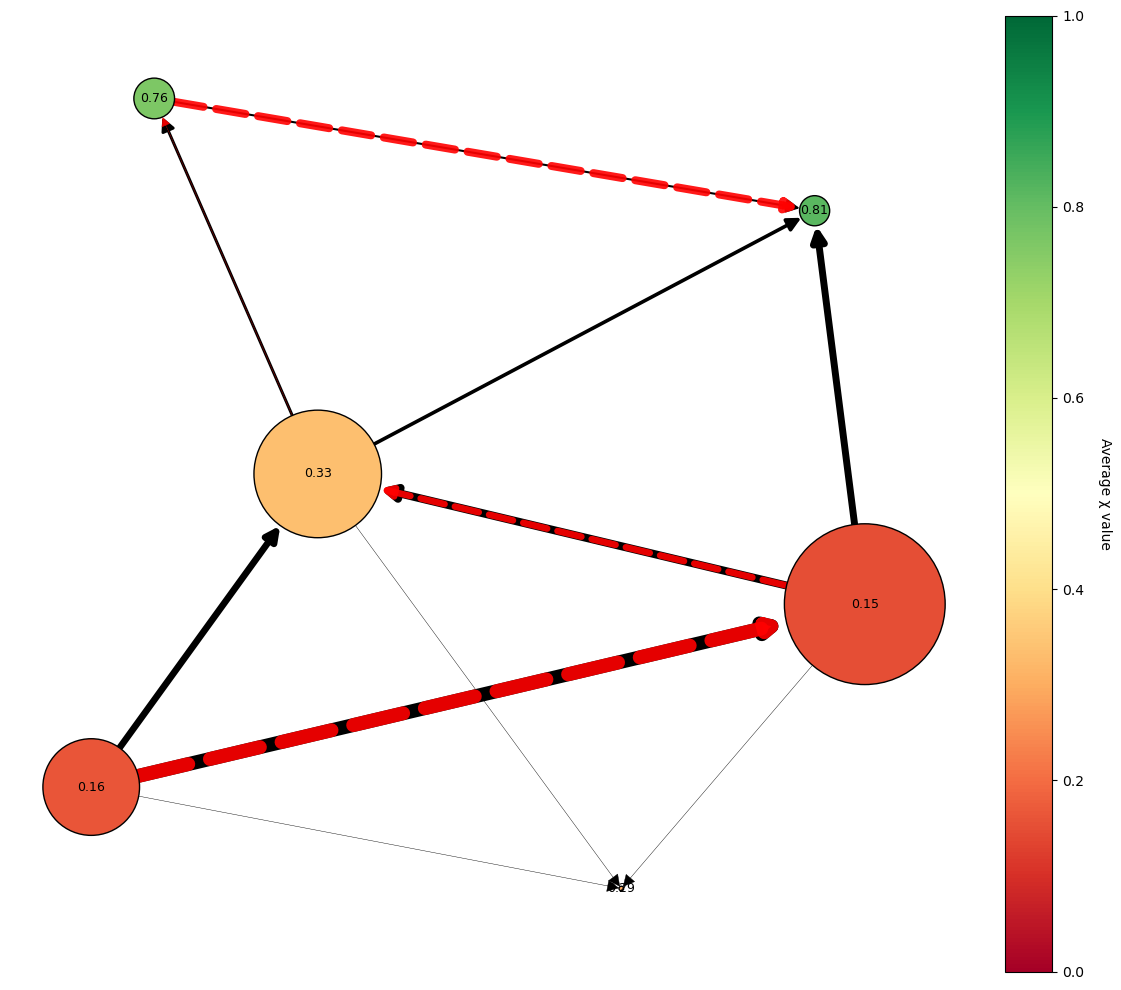

In [21]:
# # Create directed graph with weights from C but directionality from Ad.T 
## Node size is given by cluster size and nodes are colored by average chi value in the cluster
## graph is labelled by their chi value

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

# # Extract weights directly from the directed graph edges
# edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# # Normalize but enforce minimum width
# max_weight = max(edge_weights)
# edge_widths = [10 * (w / max_weight) for w in edge_weights]

# # Ensure minimum width of 0.5
# min_width = 0.5
# edge_widths = [max(w, min_width) for w in edge_widths]

fig, ax = plt.subplots(figsize=(12, 10))


# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

nx.draw_networkx_edges(Gd, pos, edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=edge_widths,#[w*0.9 for w in edge_widths],
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
chi_labels = {n: f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}

nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
                       font_size=9, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

#plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
os.makedirs('graph_results', exist_ok=True)
plt.savefig("N3intervals_results/graph_with_most_probable_path_and_mean_chi_val.pdf")

Number of paths found: 5
Best path weight: 6196.0
Best path: [5, 4, 2, 1, 0]
Found 5 paths

Top 5 paths:
Path 1: [5, 4, 2, 1, 0]
Path 2: [5, 2, 1, 0]
Path 3: [5, 1, 0]
Path 4: [5, 4, 2, 0]
Path 5: [5, 2, 0]


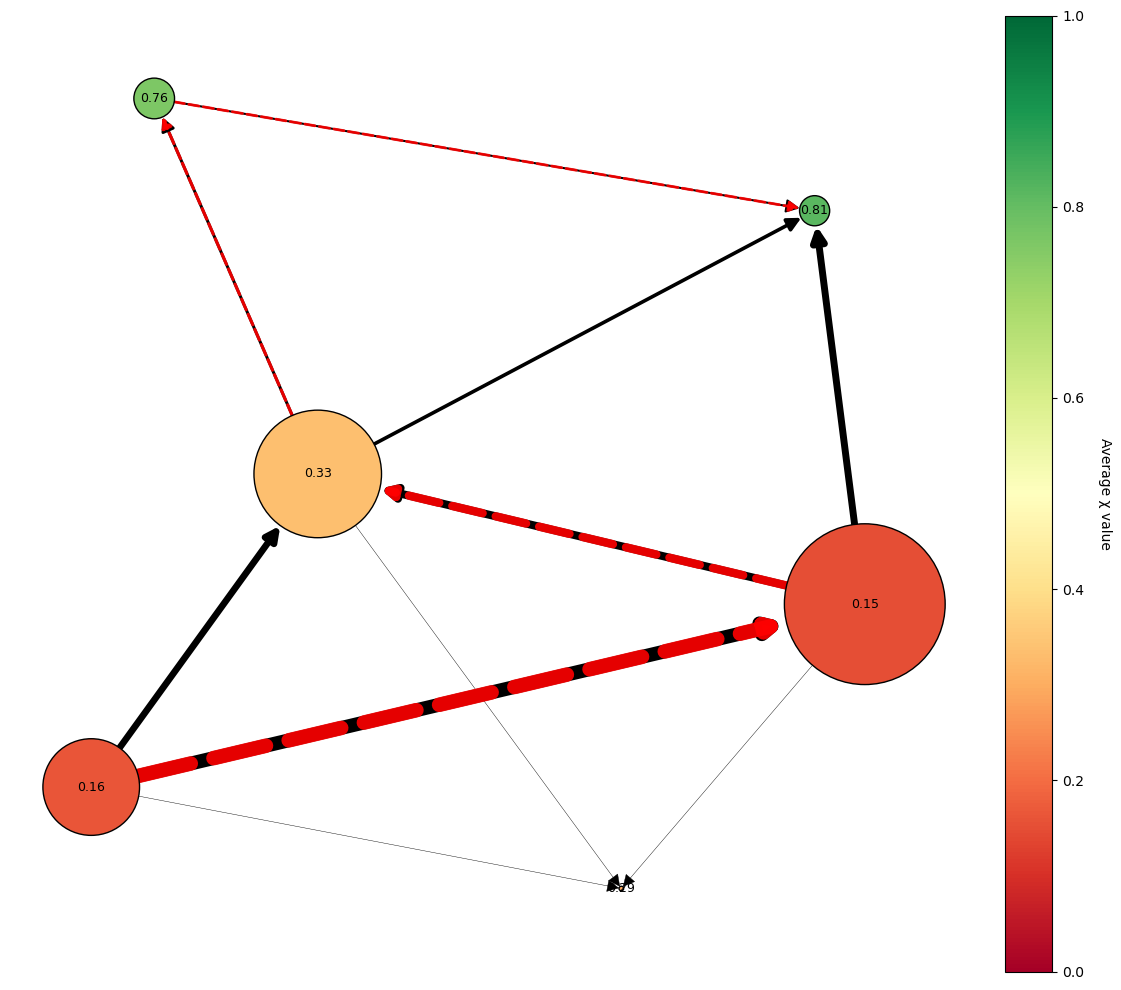

In [25]:
# # Create directed graph with weights from C but directionality from Ad.T 
## Node size is given by cluster size and nodes are colored by average chi value in the cluster
## graph is labelled by their chi value

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

# # Extract weights directly from the directed graph edges
# edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# # Normalize but enforce minimum width
# max_weight = max(edge_weights)
# edge_widths = [10 * (w / max_weight) for w in edge_weights]

# # Ensure minimum width of 0.5
# min_width = 0.5
# edge_widths = [max(w, min_width) for w in edge_widths]

fig, ax = plt.subplots(figsize=(12, 10))


# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

#======================================================
# Highlight path edges
#=======================================================
# Get the best path and its edge weights
best_path = FP.list_paths[0]
best_path_edge_weights = FP.paths_edge_weights[0]

# Reverse the path
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

# Reverse the edge weights to match the flipped path
path_edge_weights_flipped = best_path_edge_weights[::-1]

# Calculate widths using the same normalization as the overall graph
max_weight = max(edge_weights)  # Same max_weight used for all edges
path_edge_widths = [7 * (w / max_weight) for w in path_edge_weights_flipped]

# Make path edges thicker than regular edges (multiply by factor)
path_edge_widths = [w * 1.5 for w in path_edge_widths]  # 50% thicker

# Ensure minimum width
min_width = 2.0
path_edge_widths = [max(w, min_width) for w in path_edge_widths]


# Draw path edges with variable widths
nx.draw_networkx_edges(Gd, pos, 
                       edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=path_edge_widths,  # Use path-specific widths
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                       node_size=node_sizes_scaled)

#====================================================================
# Draw nodes colored by chi and sized by cluster size
#===================================================================
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
chi_labels = {n: f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}

nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
                       font_size=9, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

#plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
os.makedirs('graph_results', exist_ok=True)
plt.savefig("N3intervals_results/graph_with_most_probable_path_and_mean_chi_val.pdf")

Number of paths found: 5
Best path weight: 6196.0
Best path: [5, 4, 2, 1, 0]
Found 5 paths

Top 5 paths:
Path 1: [5, 4, 2, 1, 0]
Path 2: [5, 2, 1, 0]
Path 3: [5, 1, 0]
Path 4: [5, 4, 2, 0]
Path 5: [5, 2, 0]


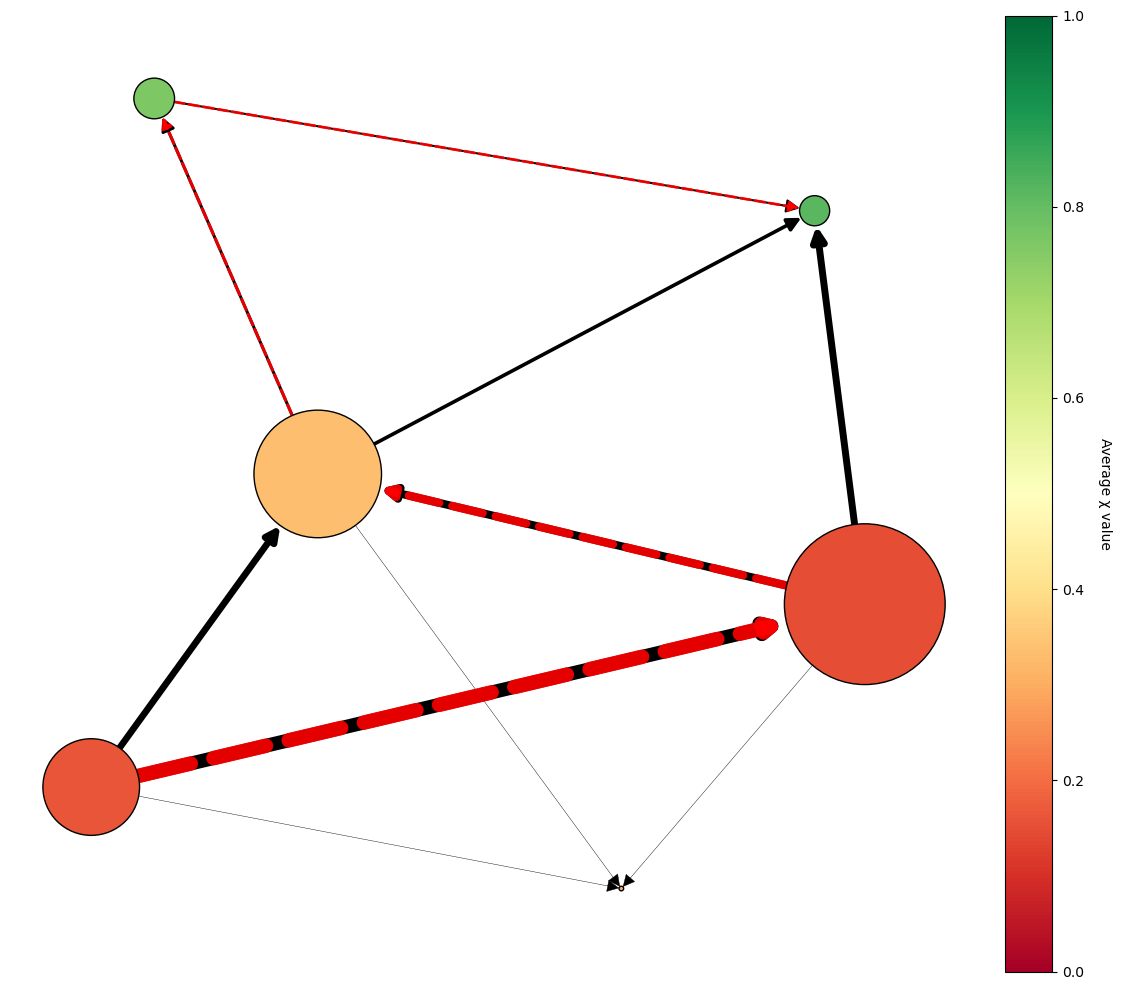

In [27]:
# # Create directed graph with weights from C but directionality from Ad.T 
## Node size is given by cluster size and nodes are colored by average chi value in the cluster
## 

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]


fig, ax = plt.subplots(figsize=(12, 10))


# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

#======================================================
# Highlight path edges
#=======================================================
# Get the best path and its edge weights
best_path = FP.list_paths[0]
best_path_edge_weights = FP.paths_edge_weights[0]

# Reverse the path
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

# Reverse the edge weights to match the flipped path
path_edge_weights_flipped = best_path_edge_weights[::-1]

# Calculate widths using the same normalization as the overall graph
max_weight = max(edge_weights)  # Same max_weight used for all edges
path_edge_widths = [7 * (w / max_weight) for w in path_edge_weights_flipped]

# Make path edges thicker than regular edges (multiply by factor)
path_edge_widths = [w * 1.5 for w in path_edge_widths]  # 50% thicker

# Ensure minimum width
min_width = 2.0
path_edge_widths = [max(w, min_width) for w in path_edge_widths]


# Draw path edges with variable widths
nx.draw_networkx_edges(Gd, pos, 
                       edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=path_edge_widths,  # Use path-specific widths
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                       node_size=node_sizes_scaled)

#====================================================================
# Draw nodes colored by chi and sized by cluster size
#===================================================================
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}

# nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
#                        font_size=9, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

#plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
os.makedirs('graph_results', exist_ok=True)
plt.savefig("N3intervals_results/graph_with_most_probable_path_and_mean_chi_val.pdf")

Number of paths found: 5
Best path weight: 6196.0
Best path: [5, 4, 2, 1, 0]
Found 5 paths

Top 5 paths:
Path 1: [5, 4, 2, 1, 0]
Path 2: [5, 2, 1, 0]
Path 3: [5, 1, 0]
Path 4: [5, 4, 2, 0]
Path 5: [5, 2, 0]


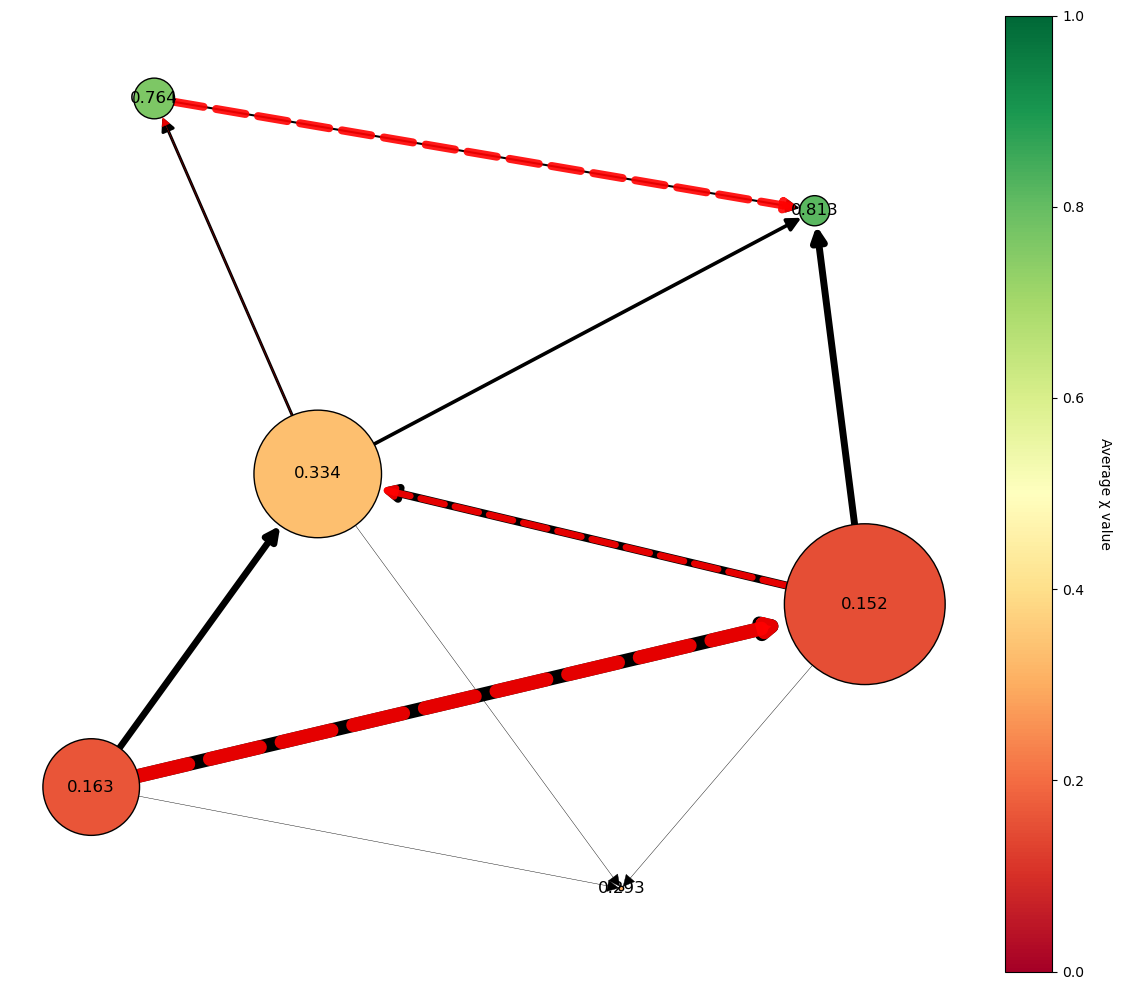

In [31]:
# # Create directed graph with weights from C but directionality from Ad.T 
## Node size is given by cluster size and nodes are colored by average chi value in the cluster
## graph is not labelled by their chi value

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

# # Extract weights directly from the directed graph edges
# edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# # Normalize but enforce minimum width
# max_weight = max(edge_weights)
# edge_widths = [10 * (w / max_weight) for w in edge_weights]

# # Ensure minimum width of 0.5
# min_width = 0.5
# edge_widths = [max(w, min_width) for w in edge_widths]

fig, ax = plt.subplots(figsize=(12, 10))


# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

nx.draw_networkx_edges(Gd, pos, edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=edge_widths,#[w*0.9 for w in edge_widths],
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
chi_labels = {n: f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}

nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
                       font_size=12, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

#plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
os.makedirs('graph_results', exist_ok=True)
plt.savefig("N3intervals_results/graph_with_most_probable_path_and_mean_chi_val_no_labels.pdf")

In [ ]:
#Graph without edges width

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)


# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]



fig, ax = plt.subplots(figsize=(12, 10))


# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.15 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=3, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

nx.draw_networkx_edges(Gd, pos, edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=edge_widths,#[w*0.9 for w in edge_widths],
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
                       font_size=12, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
# os.makedirs('graph_results', exist_ok=True)
# plt.savefig("N3intervals_results/graph_with_most_probable_path_and_mean_chi_val.pdf")

In [ ]:
# Visualize Bottlenecks
# Calculate betweenness
betweenness = nx.betweenness_centrality(BG.G, weight='weight')

# Calculate flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

# Calculate flow through each edge
edge_flows = []
for u, v in BG.G.edges():
    if BG.G.has_edge(u, v):
        # Get the weight/flow from the edge attributes
        flow = BG.G[u][v].get('weight', 1)  # Default to 1 if no weight
        edge_flows.append(flow)

# Extract weights directly from the directed graph edges
edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# Normalize but enforce minimum width
max_weight = max(edge_weights)
edge_widths = [10 * (w / max_weight) for w in edge_weights]

# Ensure minimum width of 0.5
min_width = 0.5
edge_widths = [max(w, min_width) for w in edge_widths]

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))

# Color by betweenness (bottleneck measure)
node_colors = [betweenness[n] for n in BG.G.nodes()]

# Size by flow (transition volume)
node_sizes_flow = [total_flow[n] * 0.045 for n in BG.G.nodes()]

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

nx.draw_networkx_nodes(Gd, pos, 
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=plt.cm.Reds,
                       vmin=0,
                       vmax=max(node_colors),
                       ax=ax)

nx.draw_networkx_labels(BG.G, pos, font_size=12, ax=ax)



sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                           norm=plt.Normalize(vmin=0, vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Betweenness Centrality (bottleneck)', rotation=270, labelpad=20)

plt.axis('off')
plt.tight_layout()

In [ ]:
# Visualize Bottlenecks
# Calculate betweenness
betweenness = nx.betweenness_centrality(BG.G, weight='weight')

# Calculate flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
#pos = nx.spring_layout(G, center=[0,0], seed = 27) 
# pos1 = nx.kamada_kawai_layout(BG.G)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Color by betweenness (bottleneck measure)
node_colors = [betweenness[n] for n in BG.G.nodes()]

# Size by flow (transition volume)
node_sizes_flow = [total_flow[n] * 0.045 for n in BG.G.nodes()]  # Adjust multiplier as needed

nx.draw_networkx_nodes(BG.G, pos, 
                       node_size=node_sizes_flow,
                       node_color=node_colors,
                       cmap=plt.cm.Reds,  # Red = high bottleneck
                       vmin=0,
                       vmax=max(node_colors),
                       ax=ax)

nx.draw_networkx_labels(BG.G, pos, font_size=12, ax=ax)
nx.draw_networkx_edges(BG.G, pos, width=2, alpha=0.3, ax=ax)

sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                           norm=plt.Normalize(vmin=0, vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Betweenness Centrality (bottleneck)', rotation=270, labelpad=20)

#plt.title("Network Bottlenecks (size = flow, color = betweenness)")
plt.axis('off')
plt.tight_layout()
#plt.show()
#plt.savefig("graph_results/graph_with_bottlenecks_and_flow_between_nodes.pdf")


In [ ]:
# Your count matrix: BAM.C[i,j] = number of transitions from node i to node j
C = BAM.C

# Define your basins
brown_nodes = [0, 1]
transition_nodes = [2, 3]
green_nodes = [13, 16]
all_major = brown_nodes + transition_nodes + green_nodes

print("=== PATH DEPENDENCE ANALYSIS ===\n")

# 1. TRANSITION NECESSITY: Do trajectories skip the transition phase?
print("1. Transition Phase Necessity:")
print("-" * 50)

# Direct brown→green flows
direct_brown_green = 0
for b in brown_nodes:
    for g in green_nodes:
        direct_brown_green += C[b, g]

# Brown→transition→green flows
via_transition = 0
for b in brown_nodes:
    for t in transition_nodes:
        # Flow from brown to transition
        brown_to_trans = C[b, t]
        # Flow from same transition to green
        for g in green_nodes:
            trans_to_green = C[t, g]
            # Approximate: minimum of the two flows
            via_transition += min(brown_to_trans, trans_to_green)

total_brown_to_green = direct_brown_green + via_transition

if total_brown_to_green > 0:
    print(f"Direct brown→green: {direct_brown_green} ({100*direct_brown_green/total_brown_to_green:.1f}%)")
    print(f"Via transition: {via_transition} ({100*via_transition/total_brown_to_green:.1f}%)")
    
    if direct_brown_green / total_brown_to_green < 0.1:
        print("→ ✓ TRANSITION PHASE IS NECESSARY (>90% go through it)")
    elif direct_brown_green / total_brown_to_green < 0.3:
        print("→ ⚠ TRANSITION PHASE IS IMPORTANT (>70% go through it)")
    else:
        print("→ ✗ TRANSITION PHASE IS OPTIONAL (many skip it)")
else:
    print("No brown→green transitions detected")

# 2. REVERSIBILITY: Can trajectories go backwards?
print("\n2. Reversibility Check:")
print("-" * 50)

# Green→brown flows (backwards)
green_to_brown = 0
for g in green_nodes:
    for b in brown_nodes:
        green_to_brown += C[g, b]

# Green→transition flows (partial backwards)
green_to_trans = 0
for g in green_nodes:
    for t in transition_nodes:
        green_to_trans += C[g, t]

# Forward flows for comparison
brown_to_green = direct_brown_green
brown_to_trans = sum(C[b, t] for b in brown_nodes for t in transition_nodes)

print(f"Forward (brown→green): {brown_to_green}")
print(f"Backward (green→brown): {green_to_brown}")
print(f"Forward (brown→transition): {brown_to_trans}")
print(f"Backward (green→transition): {green_to_trans}")

reversibility_ratio = green_to_brown / max(brown_to_green, 1)
print(f"Reversibility ratio: {reversibility_ratio:.3f}")

if reversibility_ratio < 0.1:
    print("→ ✓ IRREVERSIBLE (green states are absorbing)")
elif reversibility_ratio < 0.5:
    print("→ ⚠ MOSTLY IRREVERSIBLE (rare backwards transitions)")
else:
    print("→ ✗ REVERSIBLE (significant backwards flow)")

# 3. PATH DEPENDENCE: Does transition route determine green outcome?
print("\n3. Path Dependence (Route → Outcome):")
print("-" * 50)

# Create transition pathway matrix
pathway_outcomes = np.zeros((len(transition_nodes), len(green_nodes)))

for i, t_node in enumerate(transition_nodes):
    for j, g_node in enumerate(green_nodes):
        pathway_outcomes[i, j] = C[t_node, g_node]

# Normalize to get conditional probabilities
row_sums = pathway_outcomes.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Avoid division by zero
conditional_probs = pathway_outcomes / row_sums

print("\nConditional probabilities: P(green state | transition state)")
print(f"{'Transition':<15} {'→ Green 13':<15} {'→ Green 16':<15}")
print("-" * 50)

for i, t_node in enumerate(transition_nodes):
    if row_sums[i, 0] > 0:  # Only if there's flow from this transition node
        probs_str = "  ".join([f"{p:>6.1%}" for p in conditional_probs[i]])
        print(f"Node {t_node:<11} {probs_str}")

# Statistical test: Are the distributions significantly different?
# Use chi-square or simple difference
if len(transition_nodes) == 2 and len(green_nodes) == 2:
    # Simple 2x2 case
    diff = abs(conditional_probs[0, 0] - conditional_probs[1, 0])
    print(f"\nProbability difference: {diff:.1%}")
    
    if diff > 0.2 and row_sums.min() > 10:  # At least 10 transitions each
        print("→ ✓ STRONG PATH DEPENDENCE (>20% difference, sufficient data)")
    elif diff > 0.1:
        print("→ ⚠ WEAK PATH DEPENDENCE (~10-20% difference)")
    else:
        print("→ ✗ NO PATH DEPENDENCE (routes lead to same outcomes)")

# 4. DETAILED FLOW ANALYSIS
print("\n4. Detailed Flow Matrix (Major Nodes Only):")
print("-" * 50)

# Extract submatrix for major nodes
C_major = C[np.ix_(all_major, all_major)]

# Create labeled dataframe
df_flow = pd.DataFrame(C_major, 
                       index=[f"Node {n}" for n in all_major],
                       columns=[f"Node {n}" for n in all_major])

print("\nTransition counts between major states:")
print(df_flow)

# Highlight key pathways
print("\nKey pathway flows:")
for i, from_node in enumerate(all_major):
    for j, to_node in enumerate(all_major):
        flow = C_major[i, j]
        if flow > 0:
            # Classify the transition
            if from_node in brown_nodes and to_node in transition_nodes:
                trans_type = "brown→transition"
            elif from_node in transition_nodes and to_node in green_nodes:
                trans_type = "transition→green"
            elif from_node in brown_nodes and to_node in green_nodes:
                trans_type = "brown→green (DIRECT)"
            elif from_node in green_nodes and to_node in brown_nodes:
                trans_type = "green→brown (BACKWARDS)"
            else:
                trans_type = "other"
            
            print(f"  {from_node} → {to_node}: {flow:>6} transitions ({trans_type})")

# 5. SUMMARY
print("\n" + "="*50)
print("SUMMARY: Evidence for Path Dependence")
print("="*50)

evidence = []
if direct_brown_green / total_brown_to_green < 0.2:
    evidence.append("✓ Transition phase is necessary (not optional)")
if reversibility_ratio < 0.2:
    evidence.append("✓ Transitions are largely irreversible")
if len(transition_nodes) == 2 and diff > 0.15:
    evidence.append("✓ Transition route affects final green state")

if len(evidence) >= 2:
    print("Strong evidence for path-dependent dynamics:")
    for item in evidence:
        print(f"  {item}")
else:
    print("Limited evidence for path dependence:")
    print("  The system shows sequential progression but routes")
    print("  may not strongly determine final outcomes.")